In [1]:
import os
from pathlib import Path
lidc_path = Path(os.environ['DATA_ALL']) / 'TCIA-LIDC' / 'LIDC-IDRI'

In [15]:
import pydicom
# all_dicom_by_patid is a dict of dict of dict
all_dicom_by_patid = {}
for dcm_fn in list(lidc_path.glob('**/*.dcm'))[:100000]:
    dcm_instance = pydicom.dcmread(dcm_fn.as_posix(), defer_size=128)
    pat_id, series_uid, instance_num = \
        dcm_instance.PatientID, \
        dcm_instance.SeriesInstanceUID, \
        dcm_instance.InstanceNumber
    if pat_id not in all_dicom_by_patid:
        print(f"Reading instances for patient {pat_id}", end='\r')
        all_dicom_by_patid[pat_id] = {}
    dicom_for_patient = all_dicom_by_patid[pat_id]
    if series_uid not in dicom_for_patient:
        dicom_for_patient[series_uid] = {}
    assert(instance_num not in dicom_for_patient[series_uid])
    dicom_for_patient[series_uid][dcm_instance.InstanceNumber] = dcm_instance

In [21]:
for patid in sorted(all_dicom_by_patid):
    dicom_for_patient = all_dicom_by_patid[patid]    
    for series_instance_uid in dicom_for_patient:
        instance_by_num = dicom_for_patient[series_instance_uid]
        instance_nums = [int(n) for n in sorted(instance_by_num)]
        modality = instance_by_num[instance_nums[0]].Modality
        if (modality != 'CT'):
            continue
        print(f"Subject:{patid} Series:{series_instance_uid} {modality}: {min(instance_nums)}-{max(instance_nums)}")

Subject:LIDC-IDRI-0001 Series:1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192 CT: 1-133
Subject:LIDC-IDRI-0002 Series:1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919 CT: 1-261
Subject:LIDC-IDRI-0003 Series:1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264 CT: 1-140
Subject:LIDC-IDRI-0004 Series:1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228 CT: 1-241
Subject:LIDC-IDRI-0005 Series:1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225 CT: 1-133
Subject:LIDC-IDRI-0006 Series:1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957 CT: 1-133
Subject:LIDC-IDRI-0007 Series:1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680 CT: 1-145
Subject:LIDC-IDRI-0008 Series:1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954 CT: 1-133
Subject:LIDC-IDRI-0009 Series:1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572911414226912429210 CT: 1-256
Subject:LIDC-IDRI-0010 Series:1.3.6.1.4.1.14519.5.2.1.6

In [77]:
img = all_dicom_by_patid['LIDC-IDRI-0476']['1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143'][128].pixel_array

In [78]:
import cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
def filter_img(img):
    from skimage.util import img_as_uint
    img = img_as_uint(img)
    img = clahe.apply(img)
    return img

def resize_img(img, sz=128):
    from skimage.transform import resize
    img = resize(img, (sz,sz))
    return img

def whiten_img(img):
    import numpy as np
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    return img

<IPython.core.display.Javascript object>


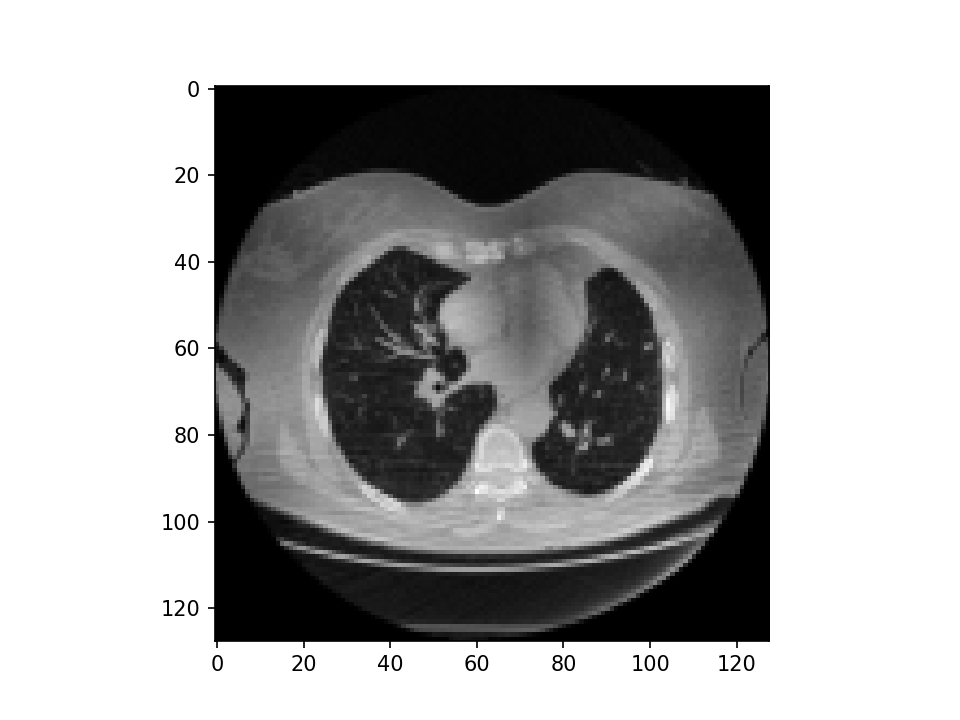

In [79]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.imshow(whiten_img(resize_img(filter_img(img))), cmap='gray')